In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from collections import Counter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('classic')
orange, purple, elm ='#FFCC00', '#666599', '#217C7E'
blue, red, grey, green ='#336699', '#9A3334', '#AAAAAA', '#335333'
%matplotlib inline
mydpi=600
s=12

__author__ = 'HK Dambanemuya'
__version__ = 'Python3'

In [2]:
themes_list = [['social distancing', 'shelter in place'],
         ['school closure', 'travel ban'],
         ['face mask', 'hand sanitizer'],
         ['medical supplies', 'test kits'],
         ['common cold', 'flu']]
themes = ['Recommendations', 'Restrictions', 'PPE', 'Medical Supplies', 'Seasonal Flu']
media = ['News', 'Blogs', 'Discussions', 'News']

In [3]:
print ("Reading News...")
news = pd.read_csv("../Data/Fusion/news.csv")
news = news[news['length']>100]
news['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(news['date'])]

print ("Reading Blogs...")
blogs = pd.read_csv("../Data/Fusion/blogs.csv")
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(blogs['date'])]

print ("Reading Discussions...")
discussions = pd.read_csv("../Data/Fusion/discussions.csv")
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(discussions['date'])]

Reading News...



Reading Blogs...



Reading Discussions...


In [4]:
def get_topic_frequency_by_media(topic_mapping):
    dates = sorted(topic_mapping.keys())
    news_v, blogs_v, discussions_v = [], [], []
    for date in dates:
        news_v.append(topic_mapping.get(date)[0])
        blogs_v.append(topic_mapping.get(date)[1])
        discussions_v.append(topic_mapping.get(date)[2])  
    return news_v, blogs_v, discussions_v

In [5]:
# Use the same sorted date list across all three datasets
dates = sorted(list(set(news['date']).union(set(blogs['date'])).union(set(discussions['date']))))[1:-1]
dates_ = [date[5:].replace('-','/') for date in dates]

In [6]:
theme_dataframes = []

for theme in tqdm_notebook(themes_list):

    var_n = news[(news['topic'].str.contains(theme[0])) | (news['topic'].str.contains(theme[1]))]
    var_b = blogs[(blogs['topic'].str.contains(theme[0])) | (blogs['topic'].str.contains(theme[1]))]
    var_d = discussions[(discussions['topic'].str.contains(theme[0])) | (discussions['topic'].str.contains(theme[1]))]
    var_news_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in var_n['date']])
    var_blogs_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in var_b['date']])
    var_discussions_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in var_d['date']])
    
    var_topic_map = {}
    for date in tqdm_notebook(sorted(dates)):
        var_topic_map[date] = [var_news_frequency.get(date, 0), 
                           var_blogs_frequency.get(date, 0), 
                           var_discussions_frequency.get(date, 0)]

    var_news_v, var_blogs_v, var_discussions_v = get_topic_frequency_by_media(var_topic_map)
    assert len(var_news_v) == len(var_blogs_v) == len(var_discussions_v)
    n= len(var_news_v)
    
    df = pd.DataFrame()
    df['News'] = pd.Series(var_news_v).rolling(7, win_type='triang').sum()
    df['Blogs'] = pd.Series(var_blogs_v).rolling(7, win_type='triang').sum()
    df['Discussions'] = pd.Series(var_discussions_v).rolling(7, win_type='triang').sum()
    theme_dataframes.append(df)

In [7]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

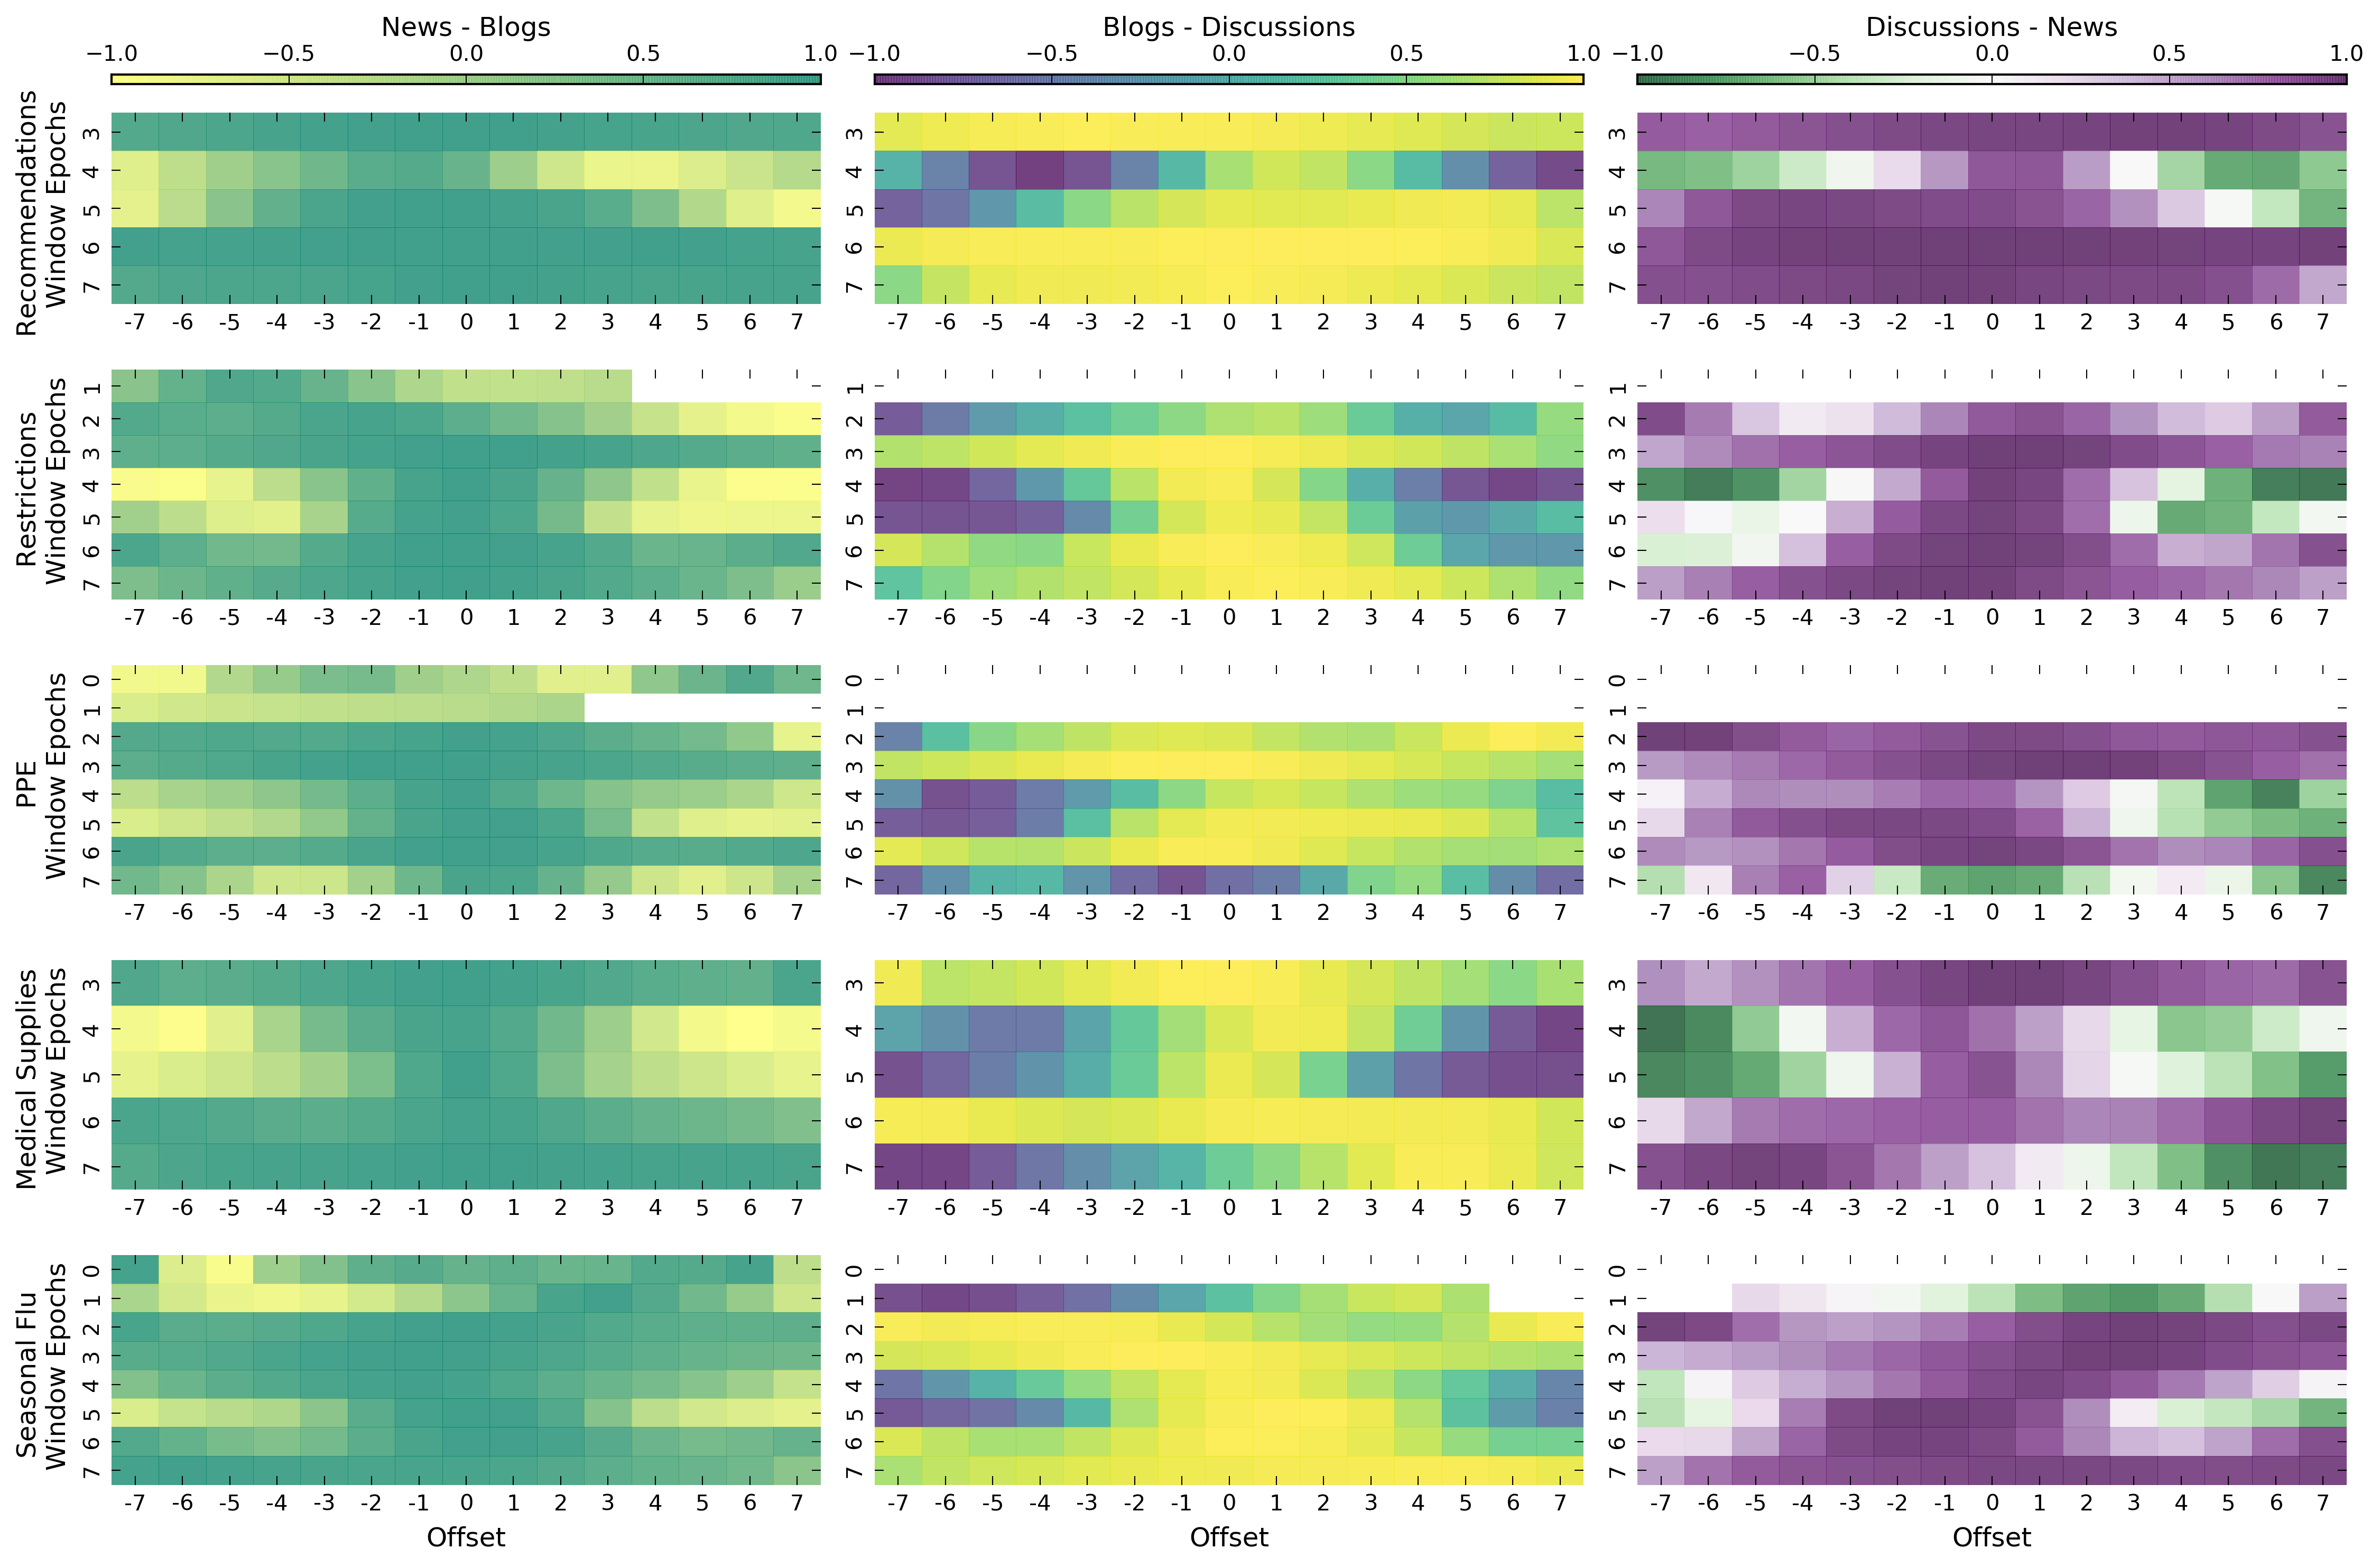

In [8]:
# Windowed time lagged cross correlation
figure, ax = plt.subplots(figsize=(15,10), sharex=True, sharey=True, dpi=300)
i = 1
for idx, df in tqdm_notebook(enumerate(theme_dataframes)):
    for j in np.arange(3):
        ax = plt.subplot(5, 3, i+j)
        no_splits = 8
        samples_per_split = df.shape[0]/no_splits
        rss=[]
        for t in range(0, no_splits):
            d1 = df[media[j]].loc[(t)*samples_per_split:(t+1)*samples_per_split]
            d2 = df[media[j+1]].loc[(t)*samples_per_split:(t+1)*samples_per_split]
            rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-7,8)]
            rss.append(rs)
        rss = pd.DataFrame(rss)
        
        if j == 0:
            sns.heatmap(rss,cmap='summer_r',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)
            ax.set_ylabel(f'{themes[idx]} \n Window Epochs', size=12)
            
        if j==1:
            sns.heatmap(rss,cmap='viridis',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)
            
        if j==2:
            sns.heatmap(rss,cmap='PRGn_r',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)
            
        if idx == 0:
            ax.set_title(f"{media[j]} - {media[j+1]}", pad=35, size=12)
            ax.set_ylim(8,3)
            
            # split axes of heatmap to put colorbar
            ax_divider = make_axes_locatable(ax)
            # define size and padding of axes for colorbar
            cax = ax_divider.append_axes('top', size = '5%', pad = '15%')
            # make colorbar for heatmap. 
            # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
            colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
            # locate colorbar ticks
            cax.xaxis.set_ticks_position('top')
            
        if idx ==1:
            ax.set_ylim(8,1)
        if idx ==3:
            ax.set_ylim(8,3)
        if idx ==4:
            ax.set_xlabel('Offset', size=12)
        
        ax.set_xticklabels(range(-7,8))
    i = i+3
plt.tight_layout()
plt.show()

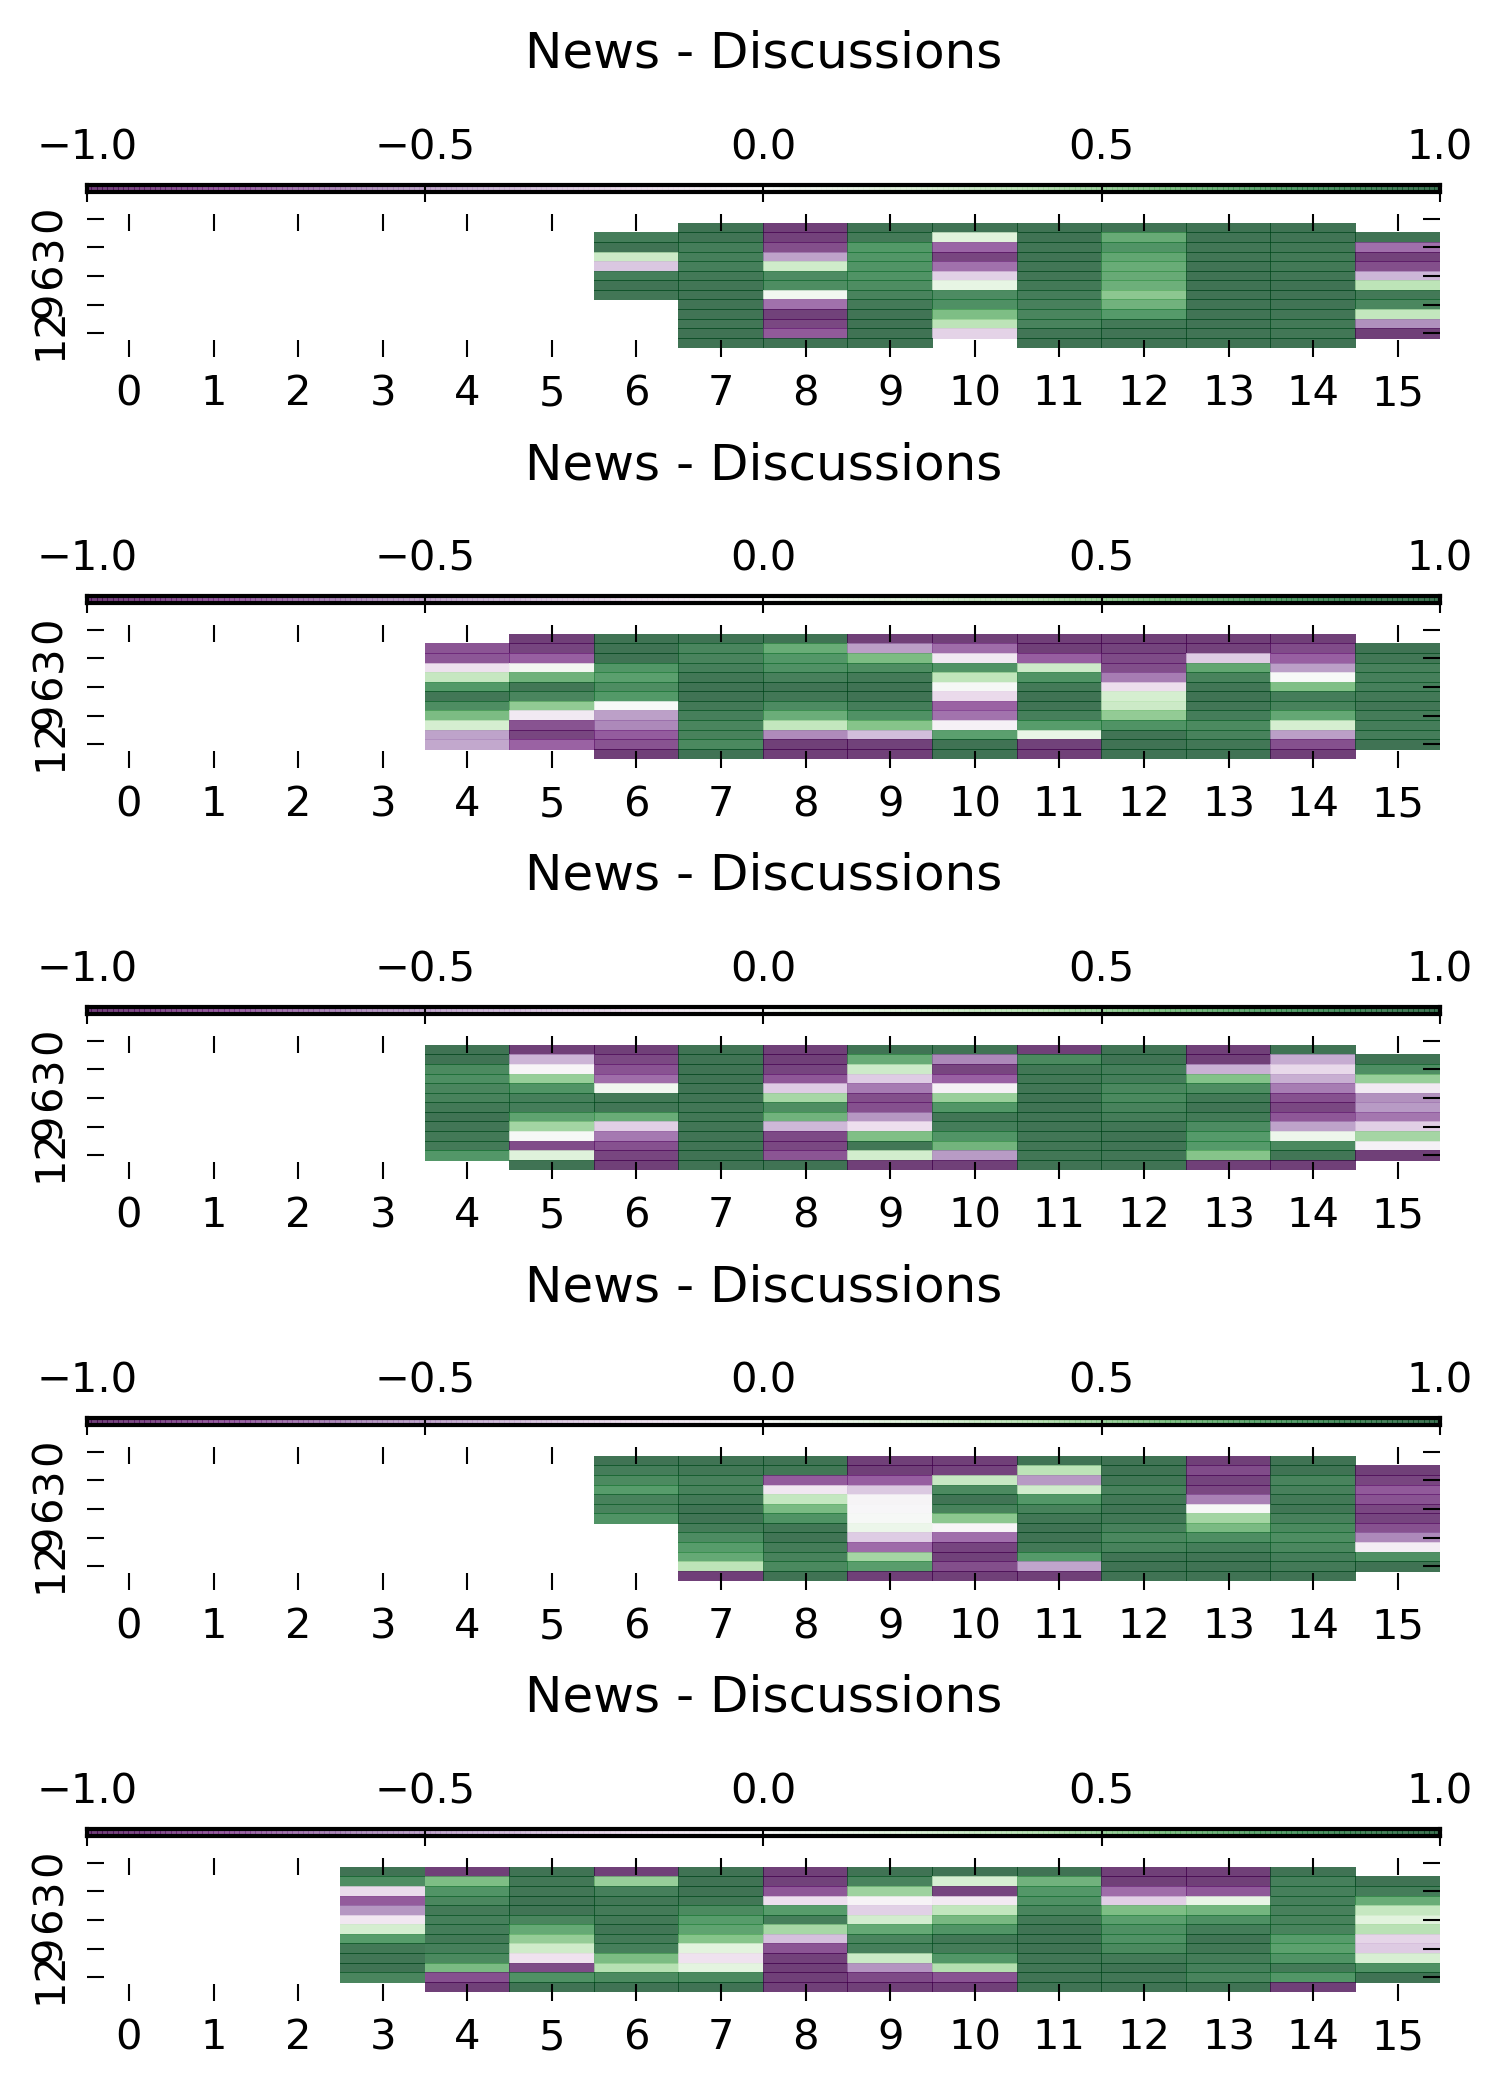

In [25]:
# Windowed time lagged cross correlation
figure, ax = plt.subplots(figsize=(5,7), sharex=True, sharey=True, dpi=300)
i = 1
for idx, df in tqdm_notebook(enumerate(theme_dataframes)):
    ax = plt.subplot(5, 1, i)
    no_splits = 16
    samples_per_split = df.shape[0]/no_splits
    rss=[]
    for t in range(0, no_splits):
        d1 = df['News'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
        d2 = df['Discussions'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
        rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-7,8)]
        rss.append(rs)
    rss = pd.DataFrame(rss).T


    ax.set_ylabel(f'{themes[idx]} \n Window Epochs', size=12)


    sns.heatmap(rss,cmap='PRGn',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)

    ax.set_title(f"News - Discussions", pad=35, size=12)

    # split axes of heatmap to put colorbar
    ax_divider = make_axes_locatable(ax)
    # define size and padding of axes for colorbar
    cax = ax_divider.append_axes('top', size = '5%', pad = '15%')
    # make colorbar for heatmap. 
    # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
    colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
    # locate colorbar ticks
    cax.xaxis.set_ticks_position('top')


    ax.set_xticklabels(range(0,no_splits))
    i = i+1
plt.tight_layout()
plt.show()

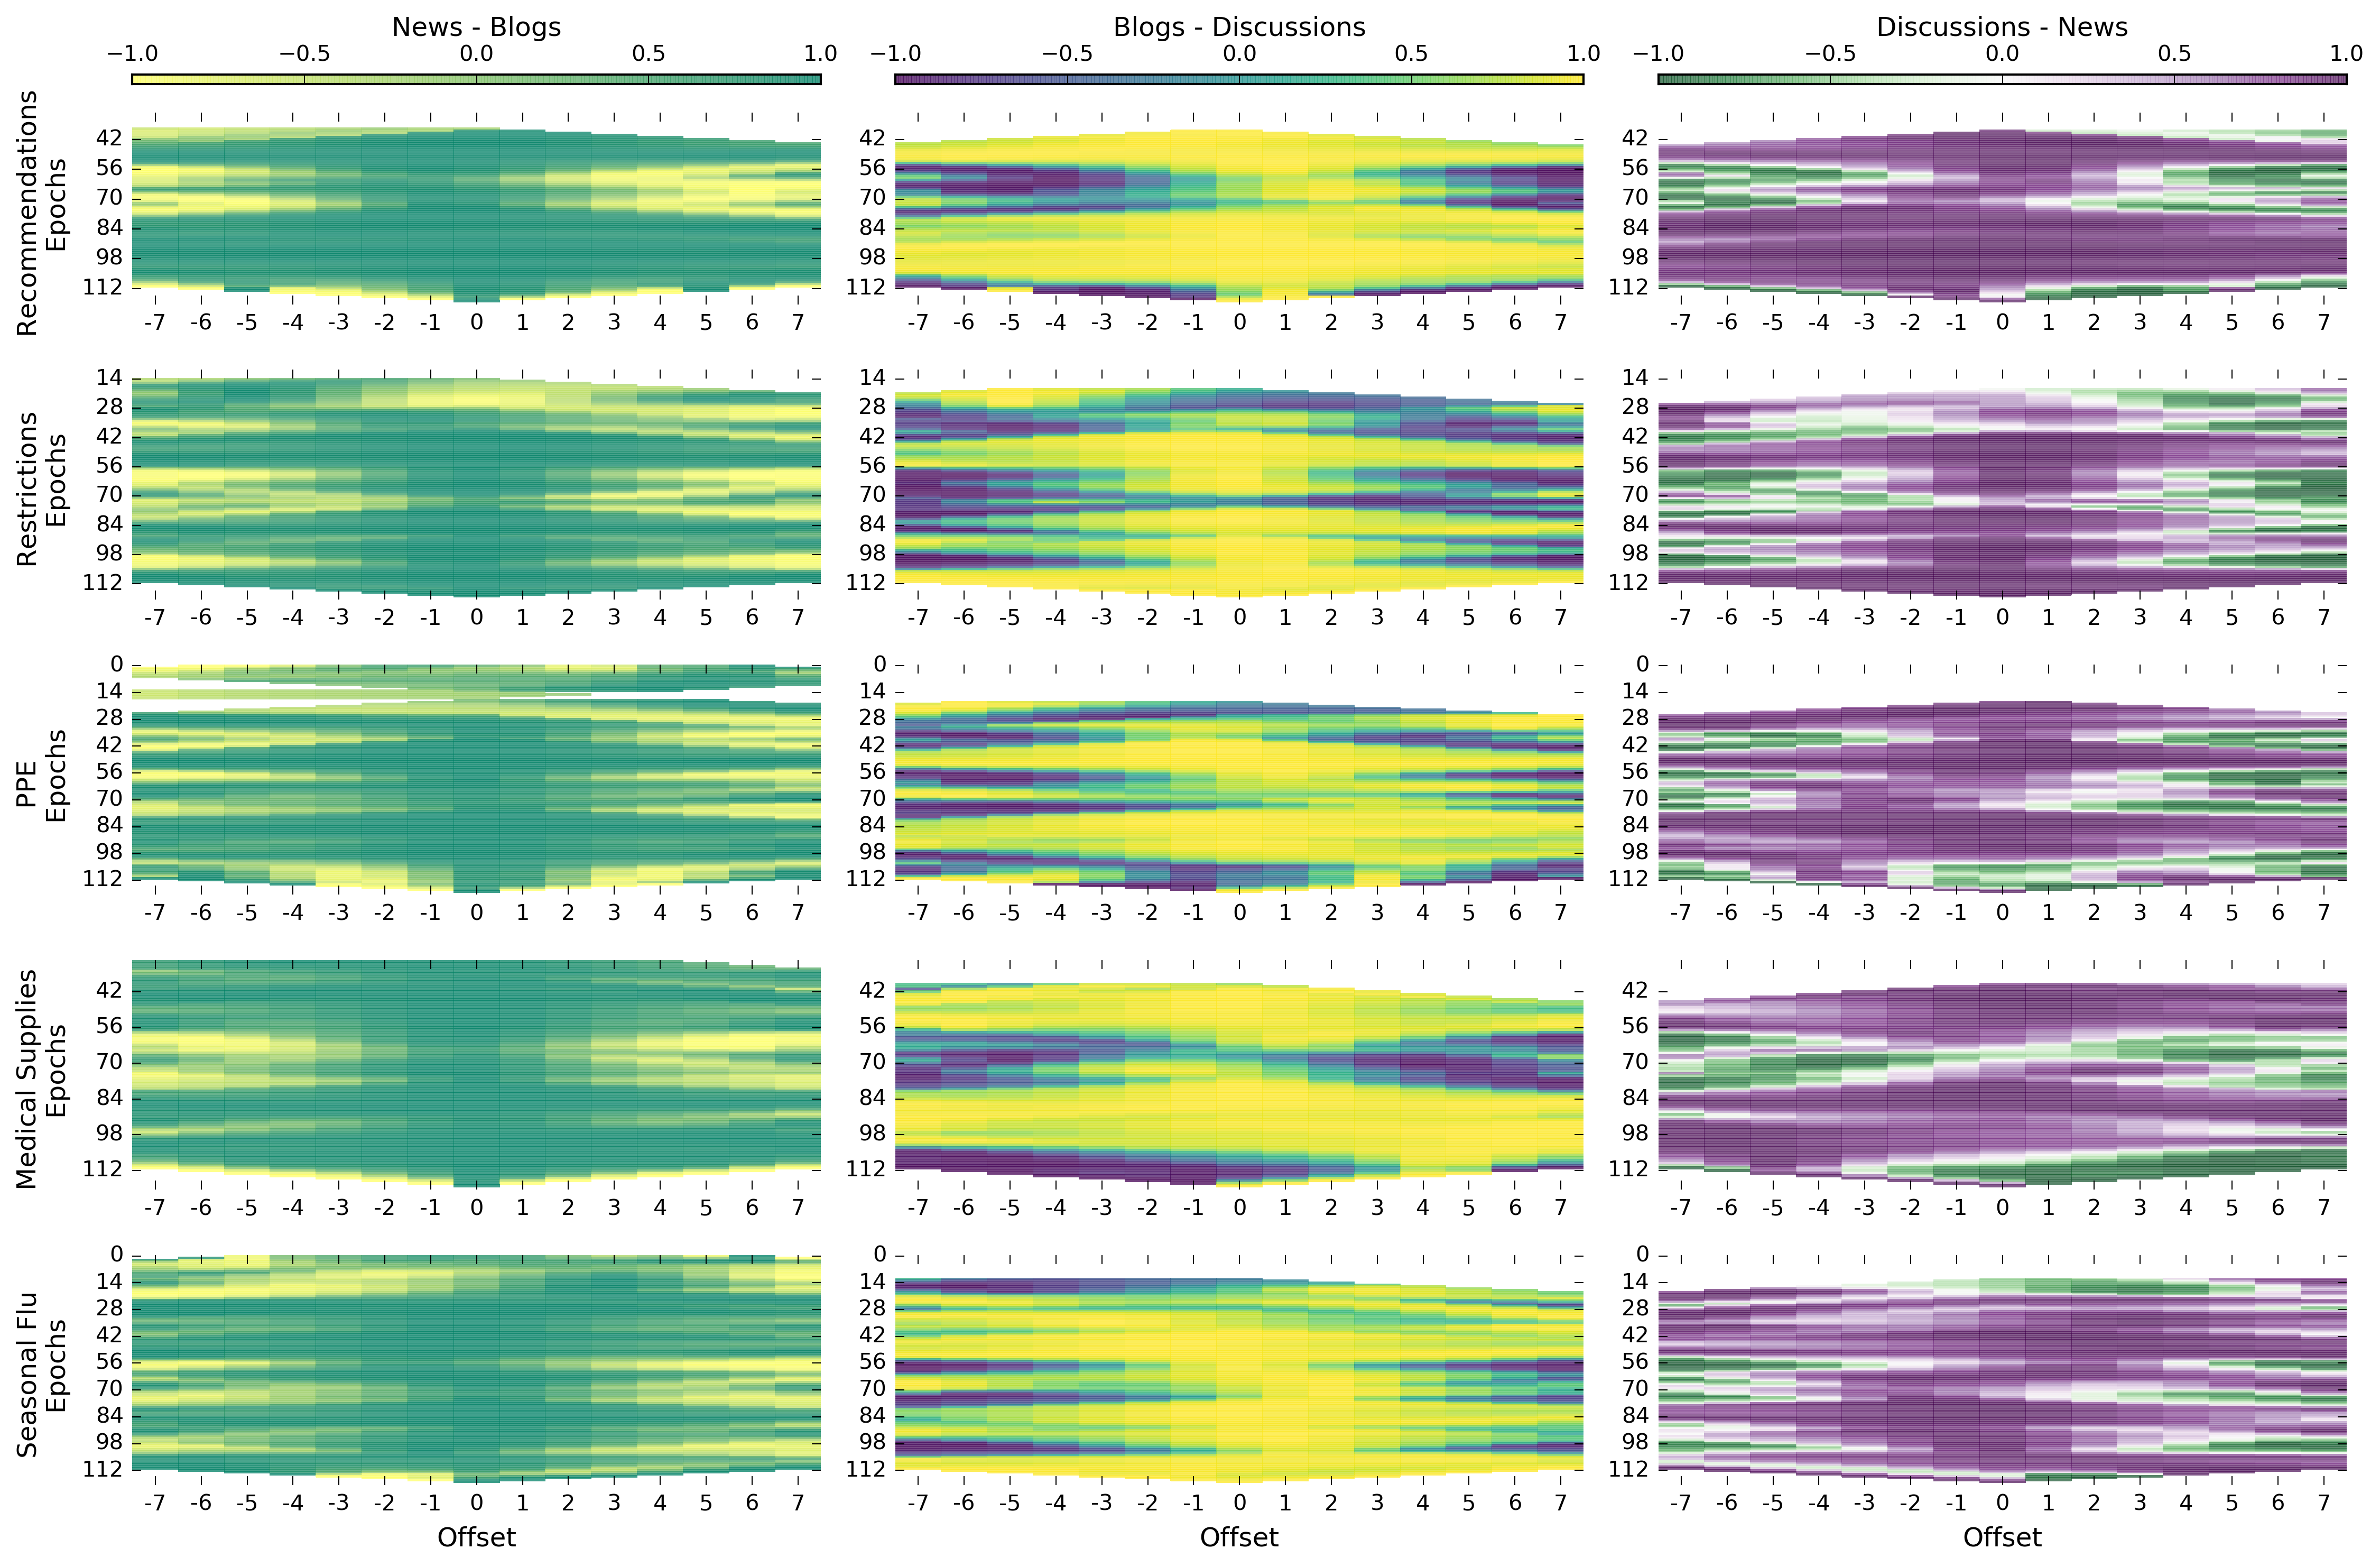

In [111]:
# Rolling window time lagged cross correlation
n=120
i = 1

figure, ax = plt.subplots(figsize=(15,10), sharex=True, sharey=True, dpi=300)


for idx, df in tqdm_notebook(enumerate(theme_dataframes)):
    for j in np.arange(3):
        
        ax = plt.subplot(5, 3, i+j)
    
        window_size = 14 #samples
        t_start = 0 # start at 0
        t_end = t_start + window_size
        step_size = 1
        rss=[]
        
        while t_end < n+window_size:
            d1 = df[media[j]].iloc[t_start:t_end]
            d2 = df[media[j+1]].iloc[t_start:t_end]
            
            rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-7,8)]
            rss.append(rs)
            t_start = t_start + step_size
            t_end = t_end + step_size
        rss = pd.DataFrame(rss)
        
        if j == 0:
            sns.heatmap(rss,cmap='summer_r',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)
            ax.set_ylabel(f'{themes[idx]} \n Epochs', size=12)
            
        if j==1:
            sns.heatmap(rss,cmap='viridis',alpha=.75,vmin=-1, vmax=1,ax=ax, cbar=False)
            
        if j==2:
            sns.heatmap(rss,cmap='PRGn_r',alpha=.65,vmin=-1, vmax=1,ax=ax, cbar=False)
        
        if idx == 0:
            ax.set_title(f"{media[j]} - {media[j+1]}", pad=35, size=12)
            ax.set_ylim(120,30)
            
            # split axes of heatmap to put colorbar
            ax_divider = make_axes_locatable(ax)
            # define size and padding of axes for colorbar
            cax = ax_divider.append_axes('top', size = '5%', pad = '15%')
            # make colorbar for heatmap. 
            # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
            colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal')
            # locate colorbar ticks
            cax.xaxis.set_ticks_position('top')
            
        if idx ==1:
            ax.set_ylim(120,10)
        if idx == 3:
            ax.set_ylim(120,30)
        if idx ==4:
            ax.set_xlabel('Offset', size=12)          
        
        ax.set_xticklabels(range(-7,8));
    i = i+3
plt.tight_layout()
plt.show()